In [81]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## LeNet5模型搭建
- 基于之前的实验内容，请在此处搭建LeNet5的CNN模型架构

In [82]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = torch.relu(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
        
loss_func = torch.nn.CrossEntropyLoss()
learning_rate = 0.01
batch_size = 16

In [83]:
# 在dataloader上计算model预测准确率的测试函数
def test(model, dataloader):
    x = torch.zeros(batch_size, 1, 28, 28, device=device)
    y = torch.LongTensor(np.zeros(batch_size)).to(device)
    correct = 0
    total = 0
    for img, label in dataloader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(batch_size, 1, 28, 28)
        for batch in range(batch_size):
            x[batch] = img[batch]
            y[batch] = label[batch]
        prediction = model(x)
        prediction = torch.argmax(prediction, dim=1)
        correct += int((prediction == y).sum())
        total += batch_size
    return correct / total

# 攻击效果受训练样本量影响的折线图绘制函数
def draw(x, y, save_name=None):
    plt.figure(figsize=(24, 16))
    plt.plot(x, y)
    plt.xlabel('Query Budget')
    plt.ylabel('Accuracy of Stolen Model')
    plt.show()
    if save_name != None:
        plt.savefig(save_name)

In [84]:
# 初始化MNIST数据集的dataloader和攻击目标模型target_model
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root="data/", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="data/", train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True)

target_model = LeNet5()
## 导入预先训练的LeNet5目标模型
params = torch.load('./model/lenet5.pt')
target_model.load_state_dict(params)

C:\Users\w2213\AppData\Local\Temp\ipykernel_41800\1376579149.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load('./model/lenet5.pt')


<All keys matched successfully>

In [85]:
# 模型窃取攻击实验超参初始化
query_budgets = [200, 100, 50]
target_model = target_model.to(device)
epoches_list = [50, 100, 200]
tau = 1

## 模型窃取攻击
- 如实验说明中介绍，简单的模型窃取攻击可能有2种loss设计方式：
    1. 利用平方差函数衡量窃取模型和目标模型的输出差异，然后通过训练最小化这一差异
    2. 通过softmax归一化窃取模型和目标模型的输出，用KL散度衡量归一化后两者的输出差异，然后通过训练最小化这一差异
- 下面请大家按照上述2个设计思路，实现模型窃取攻击
    1. 对于形式一而言，大家在计算loss时可能用到的函数有：
        - torch.norm(input, p, dim)：计算input的L_p范数
            - input：需要计算L_p范数的Tensor类型数据
            - p：L_p范数的p的取值，当前场景下可以直接令p=2
            - dim: L_p范数的计算维度，如果有给输入值，即只对dim对应维度的数据计算L_p范数
        - torch.mean(input, dim)：计算input所有元素的平均值
            - input：需要计算均值的Tensor类型数据
            - dim: 求和函数的计算维度，如果有给输入值，则只对dim对应维度的数据求均值
    1. 对于形式二而言，大家在计算loss时可能用到的函数有：
        - torch.softmax(input, dim)：计算input的softmax激活值
            - input：需要计算softmax激活值的Tensor类型数据
            - dim: softmax函数的计算维度，如果有给输入值，即只对dim对应维度的数据计算softmax激活值
        - torch.sum(input, dim)：计算input所有元素的和
            - input：需要求和的Tensor类型数据
            - dim: 求和函数的计算维度，如果有给输入值，则只对dim对应维度的数据求和
        - torch.mean(input)：计算input所有元素的平均值，详细介绍同上
        - torch.log(input): 计算input种每个元素的对数值
            - input：需要求对数的Tensor类型数据
    3. 除此之外，steal_model和之前的模型训练过程是一致的，先用优化器清零梯度，然后计算loss并反向传播梯度，最后用优化器更新模型。具体使用的函数这里不再介绍。

##### Experiment on query_budget=200, training_epoch=50 #####
Test Accuracy =  0.9581
Test Accuracy =  0.9599
Test Accuracy =  0.9609
Test Accuracy =  0.9643
Test Accuracy =  0.9652
##### Experiment on query_budget=100, training_epoch=50 #####
Test Accuracy =  0.9462
Test Accuracy =  0.9568
Test Accuracy =  0.9545
Test Accuracy =  0.9619
Test Accuracy =  0.9602
##### Experiment on query_budget=50, training_epoch=50 #####
Test Accuracy =  0.924
Test Accuracy =  0.9478
Test Accuracy =  0.9534
Test Accuracy =  0.9581
Test Accuracy =  0.9596


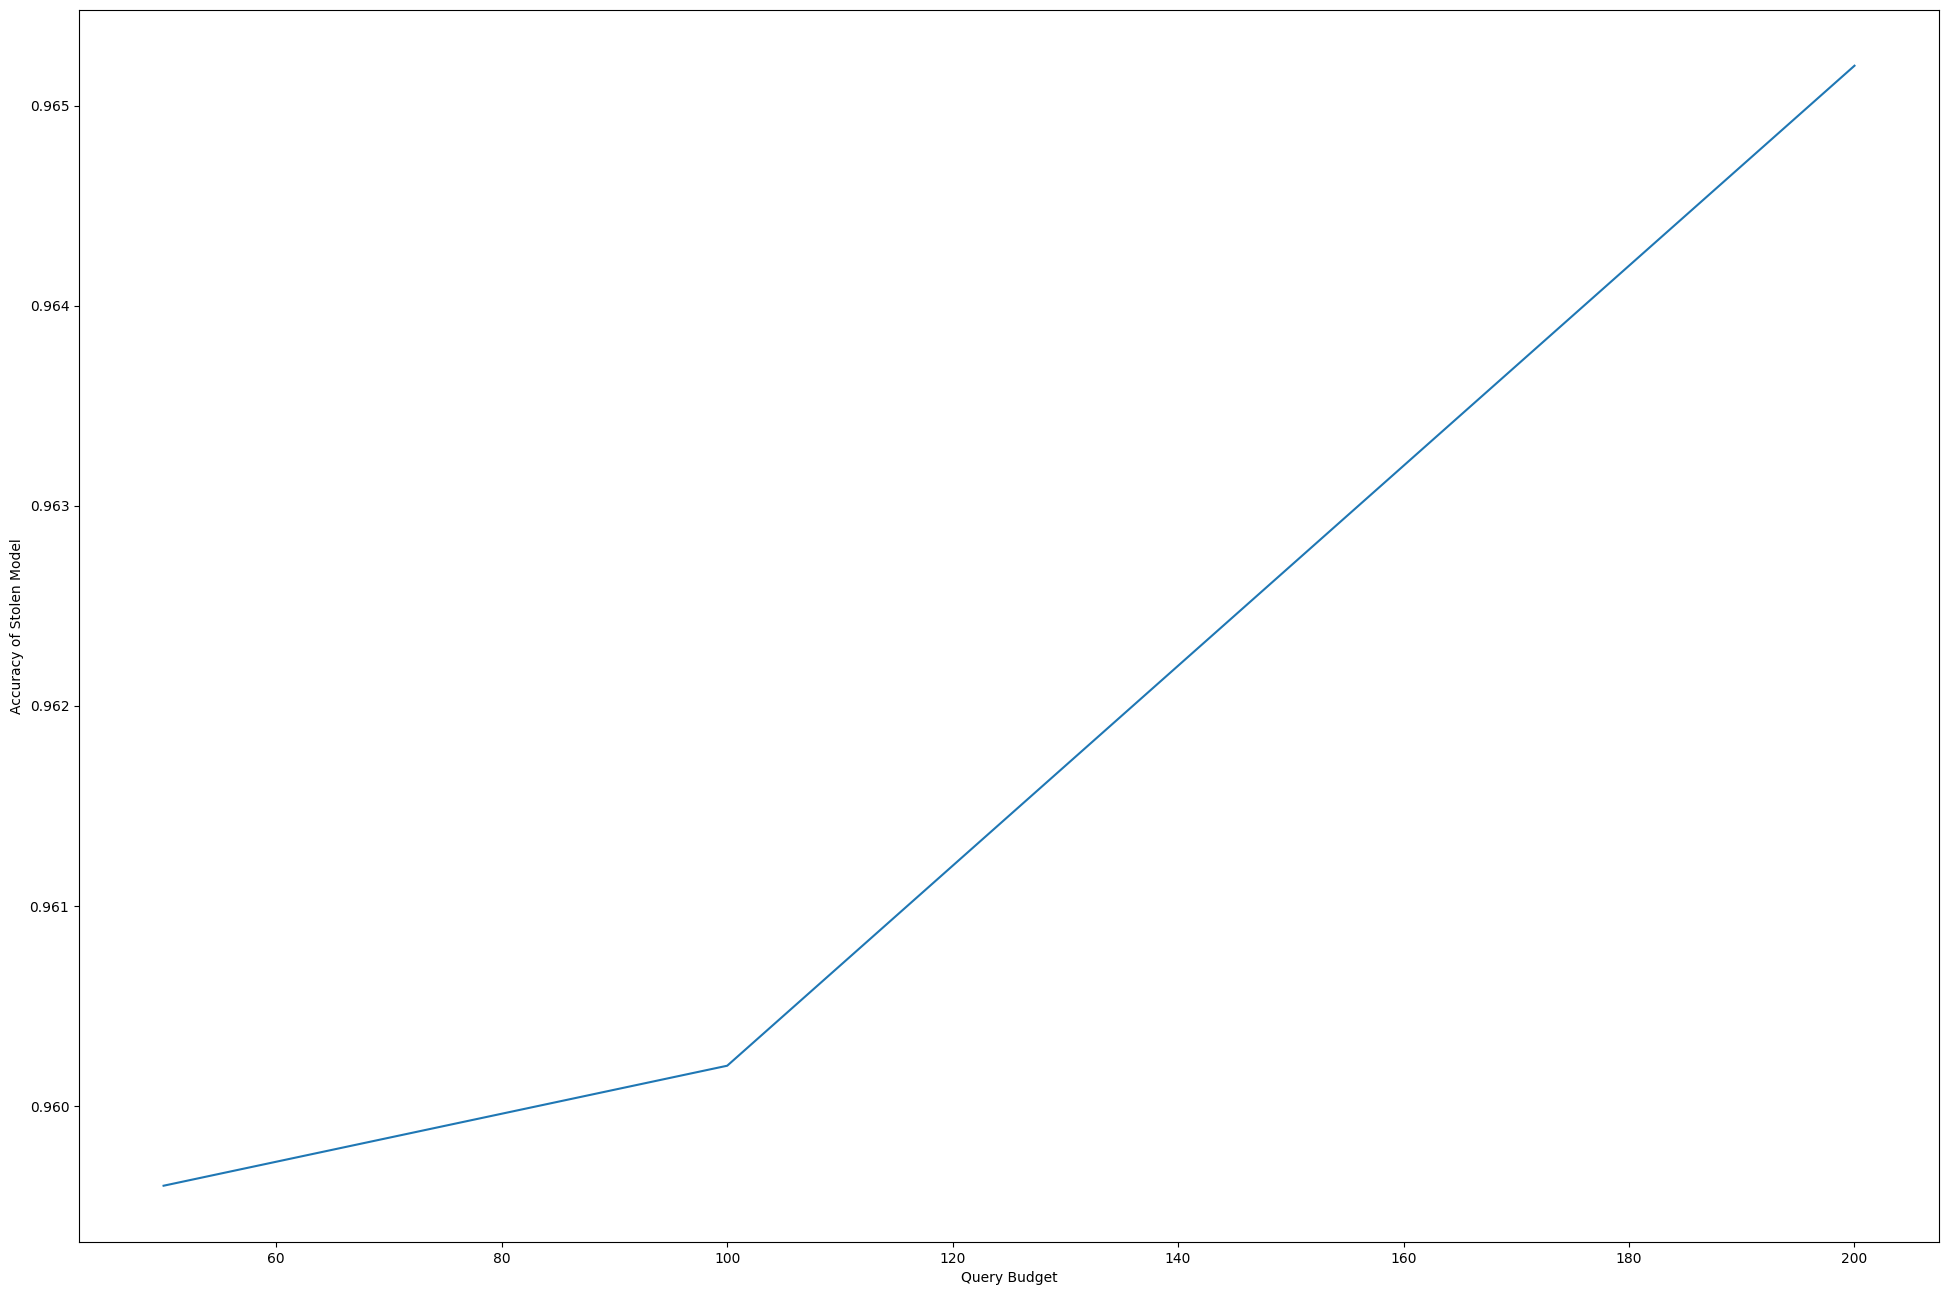

##### Experiment on query_budget=200, training_epoch=100 #####
Test Accuracy =  0.9585
Test Accuracy =  0.9641
Test Accuracy =  0.9596
Test Accuracy =  0.9648
Test Accuracy =  0.9656
Test Accuracy =  0.965
Test Accuracy =  0.9655
Test Accuracy =  0.9657
Test Accuracy =  0.9648
Test Accuracy =  0.9653
##### Experiment on query_budget=100, training_epoch=100 #####
Test Accuracy =  0.9439
Test Accuracy =  0.959
Test Accuracy =  0.9569
Test Accuracy =  0.9561
Test Accuracy =  0.9607
Test Accuracy =  0.9603
Test Accuracy =  0.9608
Test Accuracy =  0.9619
Test Accuracy =  0.9615
Test Accuracy =  0.9631
##### Experiment on query_budget=50, training_epoch=100 #####
Test Accuracy =  0.9118
Test Accuracy =  0.9428
Test Accuracy =  0.9475
Test Accuracy =  0.9539
Test Accuracy =  0.9521
Test Accuracy =  0.9564
Test Accuracy =  0.9587
Test Accuracy =  0.9541
Test Accuracy =  0.9576
Test Accuracy =  0.9557


<Figure size 640x480 with 0 Axes>

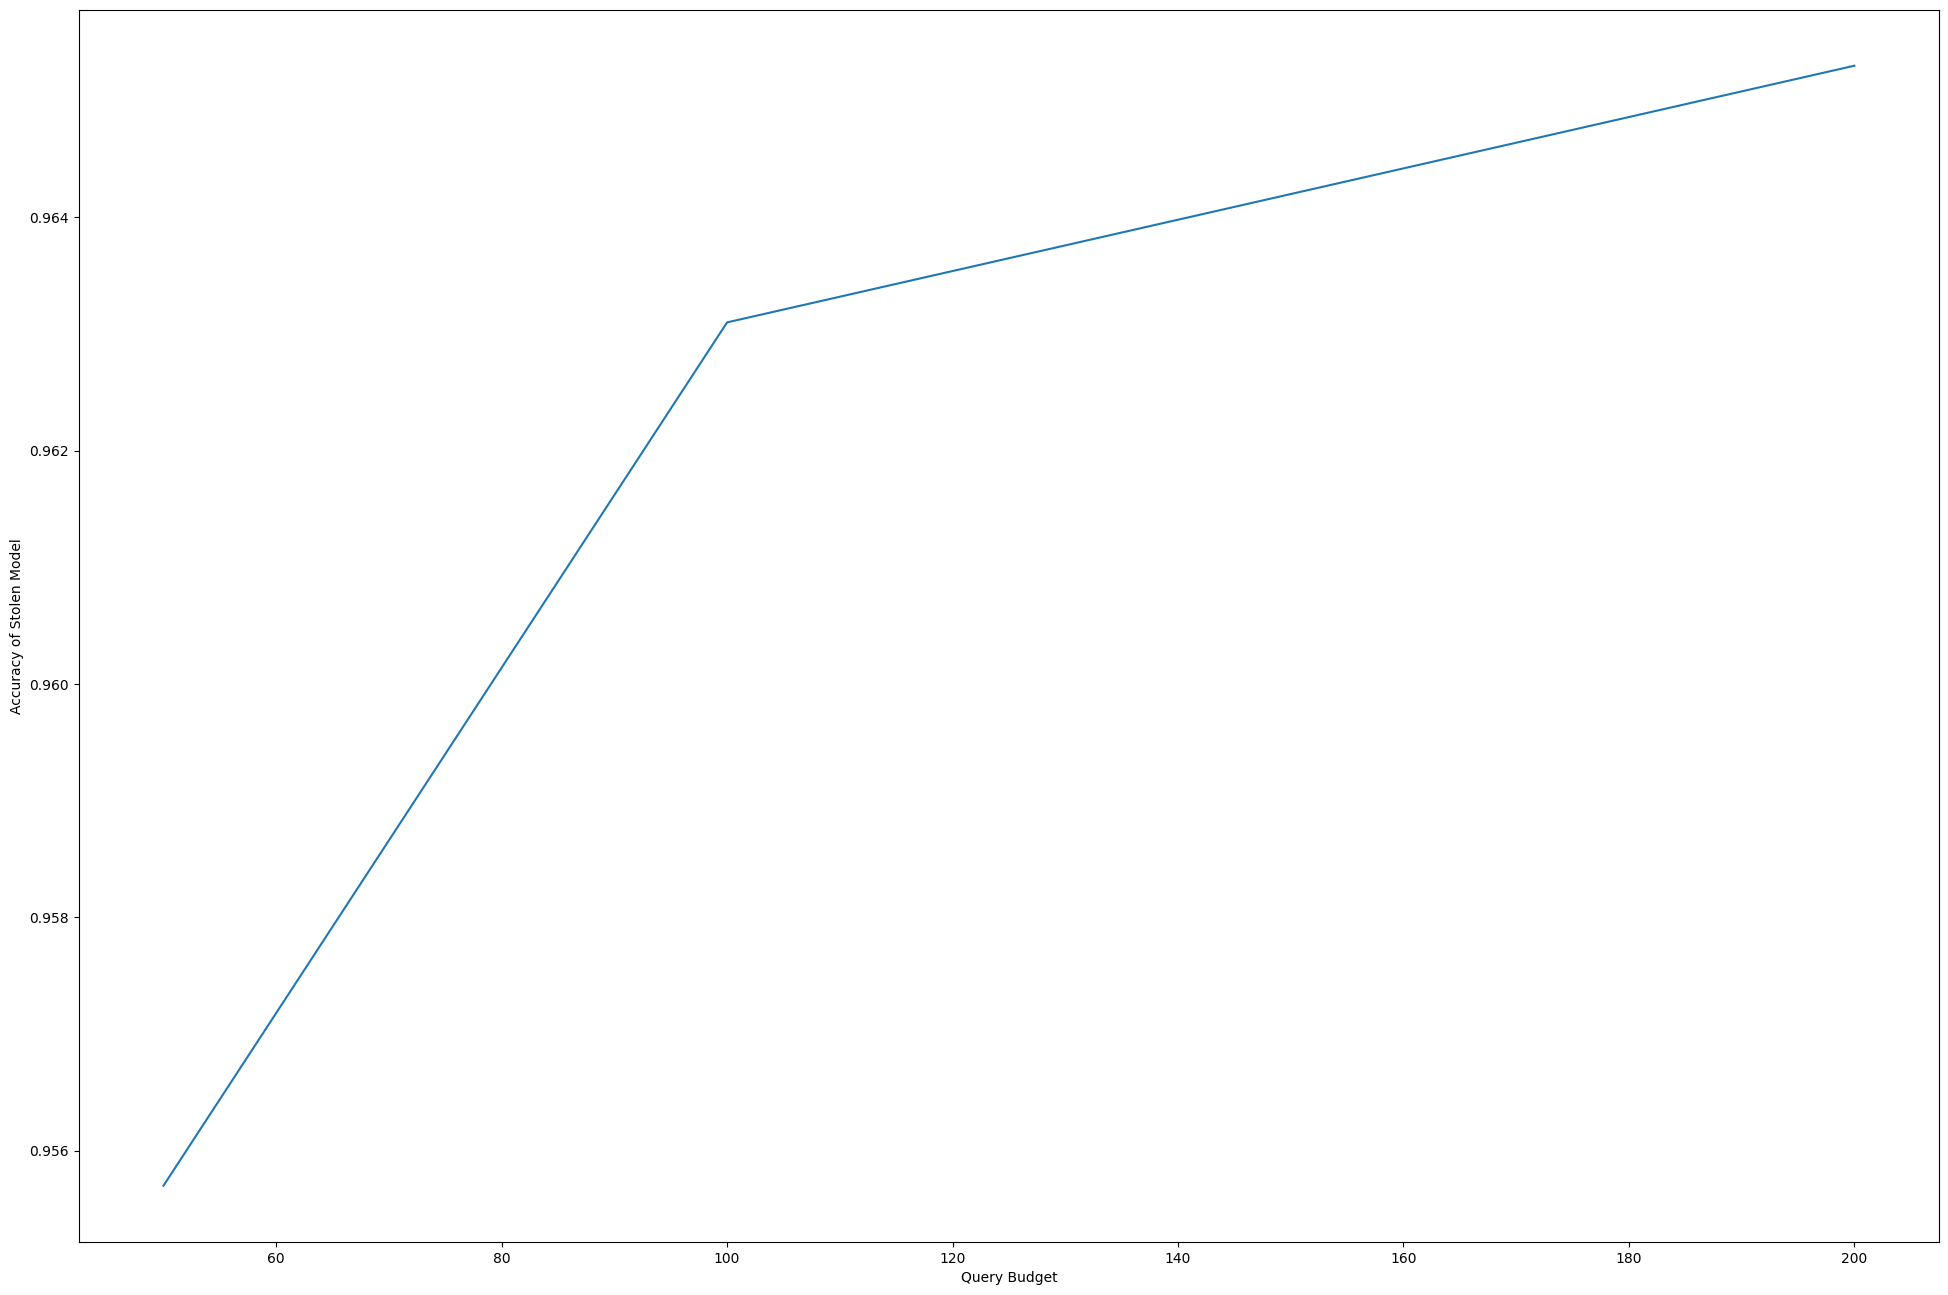

##### Experiment on query_budget=200, training_epoch=200 #####
Test Accuracy =  0.9581
Test Accuracy =  0.9628
Test Accuracy =  0.9631
Test Accuracy =  0.9661
Test Accuracy =  0.9655
Test Accuracy =  0.9655
Test Accuracy =  0.9661
Test Accuracy =  0.9642
Test Accuracy =  0.9653
Test Accuracy =  0.9654
Test Accuracy =  0.9652
Test Accuracy =  0.9669
Test Accuracy =  0.965
Test Accuracy =  0.964
Test Accuracy =  0.9655
Test Accuracy =  0.9659
Test Accuracy =  0.9663
Test Accuracy =  0.9659
Test Accuracy =  0.9661
Test Accuracy =  0.9649
##### Experiment on query_budget=100, training_epoch=200 #####
Test Accuracy =  0.9499
Test Accuracy =  0.9469
Test Accuracy =  0.9572
Test Accuracy =  0.9603
Test Accuracy =  0.9629
Test Accuracy =  0.9599
Test Accuracy =  0.9632
Test Accuracy =  0.9625
Test Accuracy =  0.9649
Test Accuracy =  0.9639
Test Accuracy =  0.9656
Test Accuracy =  0.9646
Test Accuracy =  0.9635
Test Accuracy =  0.964
Test Accuracy =  0.9648
Test Accuracy =  0.9637
Test Accuracy

<Figure size 640x480 with 0 Axes>

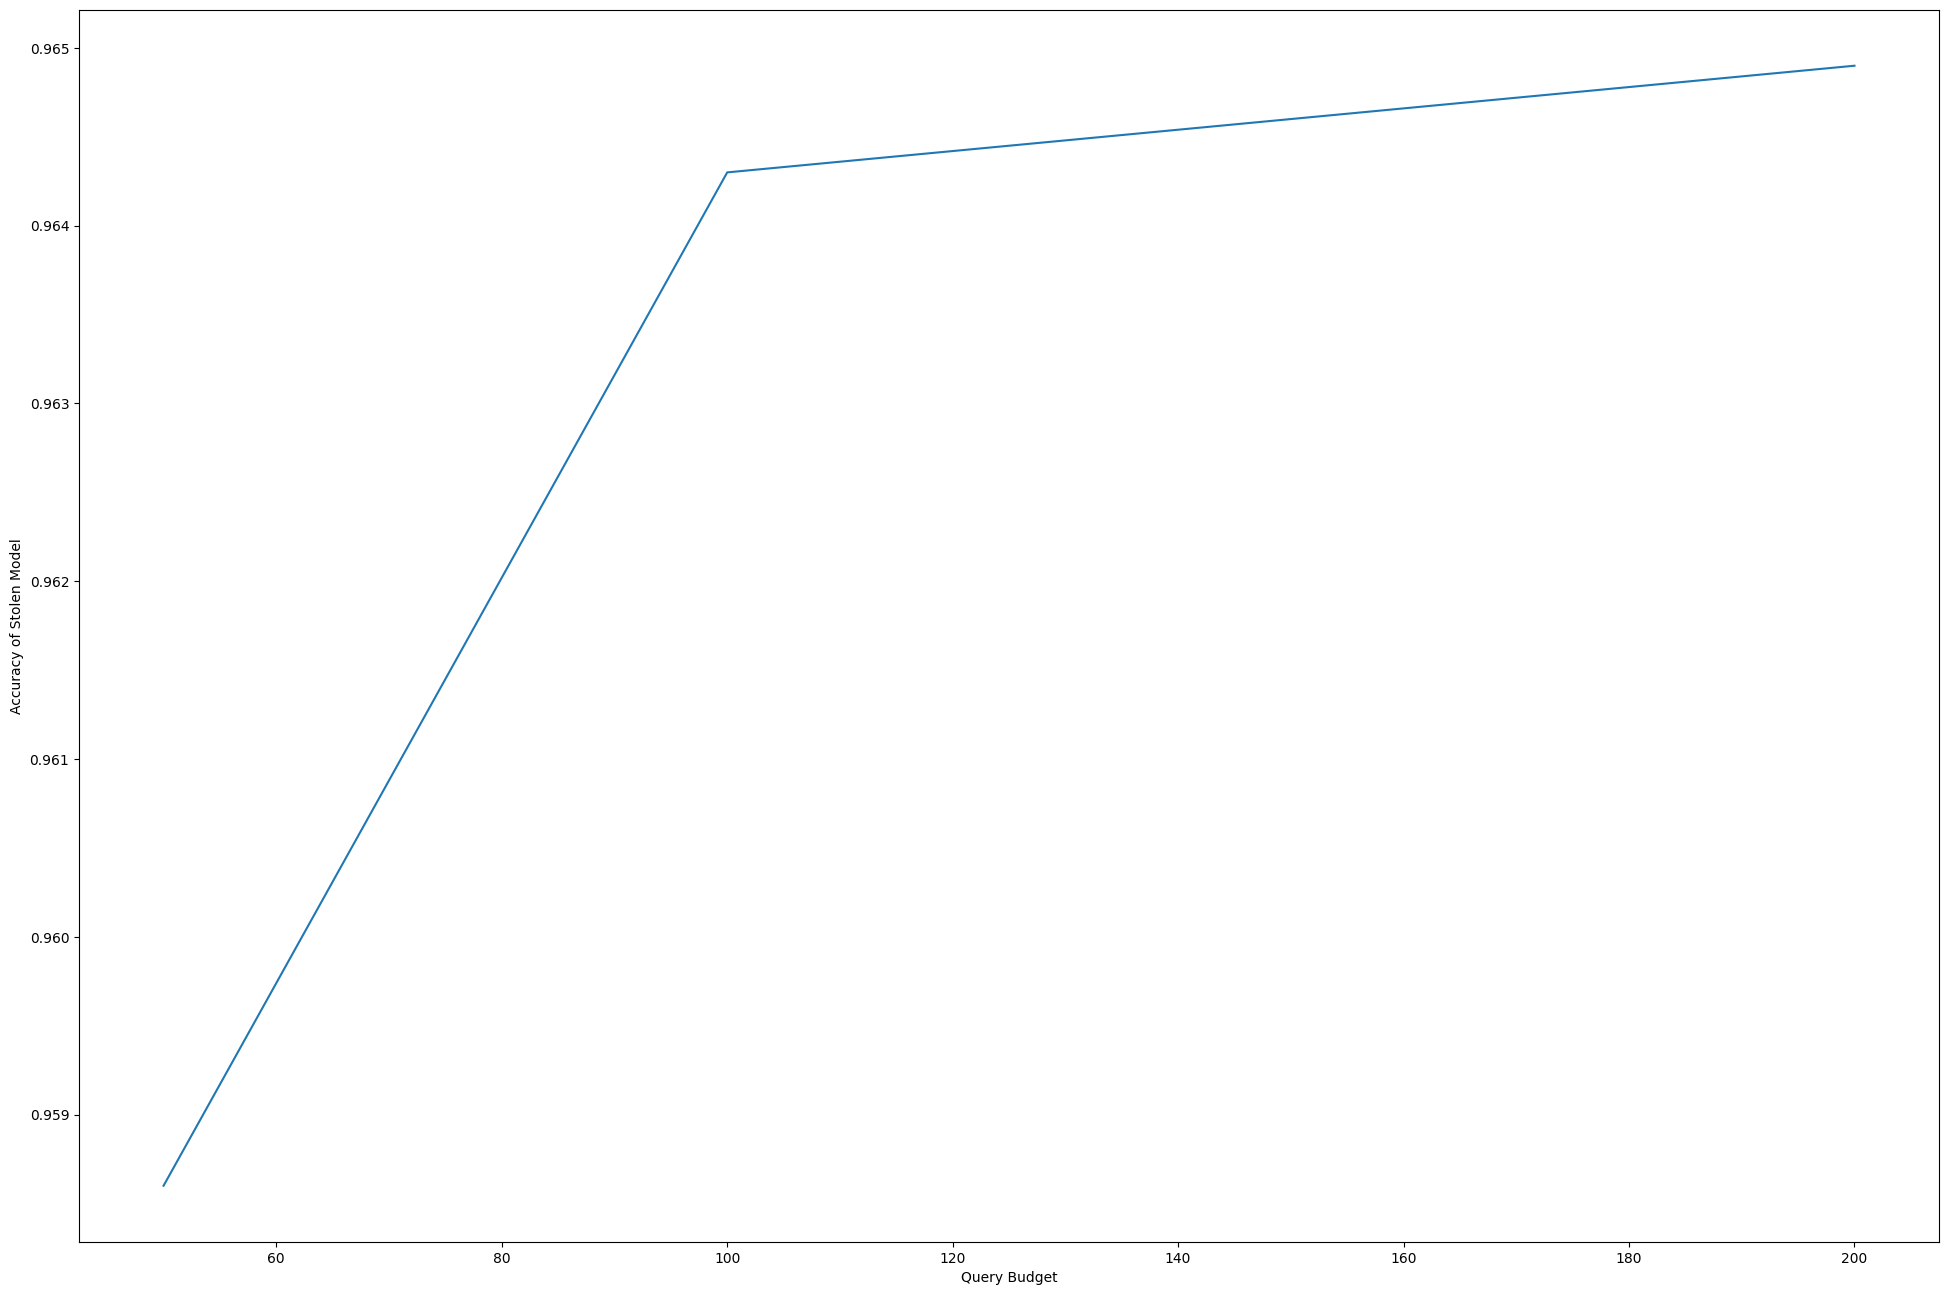

<Figure size 640x480 with 0 Axes>

In [86]:
# 攻击形式一
for epoches in epoches_list:
    acc_list = []
    
    for query_budget in query_budgets:
        print('##### Experiment on query_budget={}, training_epoch={} #####'.format(query_budget, epoches))
        # 初始化窃取模型
        query_set = np.load('Week13_MNIST_budget={}.npy'.format(query_budget), allow_pickle=True)
        steal_model = LeNet5().to(device)
        optimizer = torch.optim.SGD(steal_model.parameters(), lr=learning_rate)
        x = torch.zeros(batch_size, 1, 28, 28, dtype=torch.float, device=device)
        y = torch.zeros(batch_size, 10, dtype=torch.float, device=device)
        
        for epoch in range(1, epoches + 1):
            for img, label in query_set:
                img = img.to(device)
                label = label.to(device)
                img = img.view(batch_size, 1, 28, 28)
                for batch in range(batch_size):
                    x[batch] = img[batch]
                    y[batch] = label[batch]
                # TODO：实现模型预测，loss计算和反传梯度的功能
                prediction = steal_model(x)
                l2_norms = torch.norm(prediction - y, p=2, dim=1)
                loss = torch.mean(l2_norms)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
            if epoch % 10 == 0:
                test_accuracy = test(steal_model, test_loader)
                print("Test Accuracy = ", test_accuracy)
        acc_list.append(test_accuracy)
        
    draw(query_budgets, acc_list, save_name='MNIST_L2Steal_Epoches={}.png'.format(epoches))

##### Experiment on query_budget=200, training_epoch=50 #####
Test Accuracy =  0.9487
Test Accuracy =  0.9611
Test Accuracy =  0.9645
Test Accuracy =  0.9659
Test Accuracy =  0.9673
##### Experiment on query_budget=100, training_epoch=50 #####
Test Accuracy =  0.9119
Test Accuracy =  0.9427
Test Accuracy =  0.9509
Test Accuracy =  0.9548
Test Accuracy =  0.958
##### Experiment on query_budget=50, training_epoch=50 #####
Test Accuracy =  0.8243
Test Accuracy =  0.9182
Test Accuracy =  0.9309
Test Accuracy =  0.9362
Test Accuracy =  0.9385


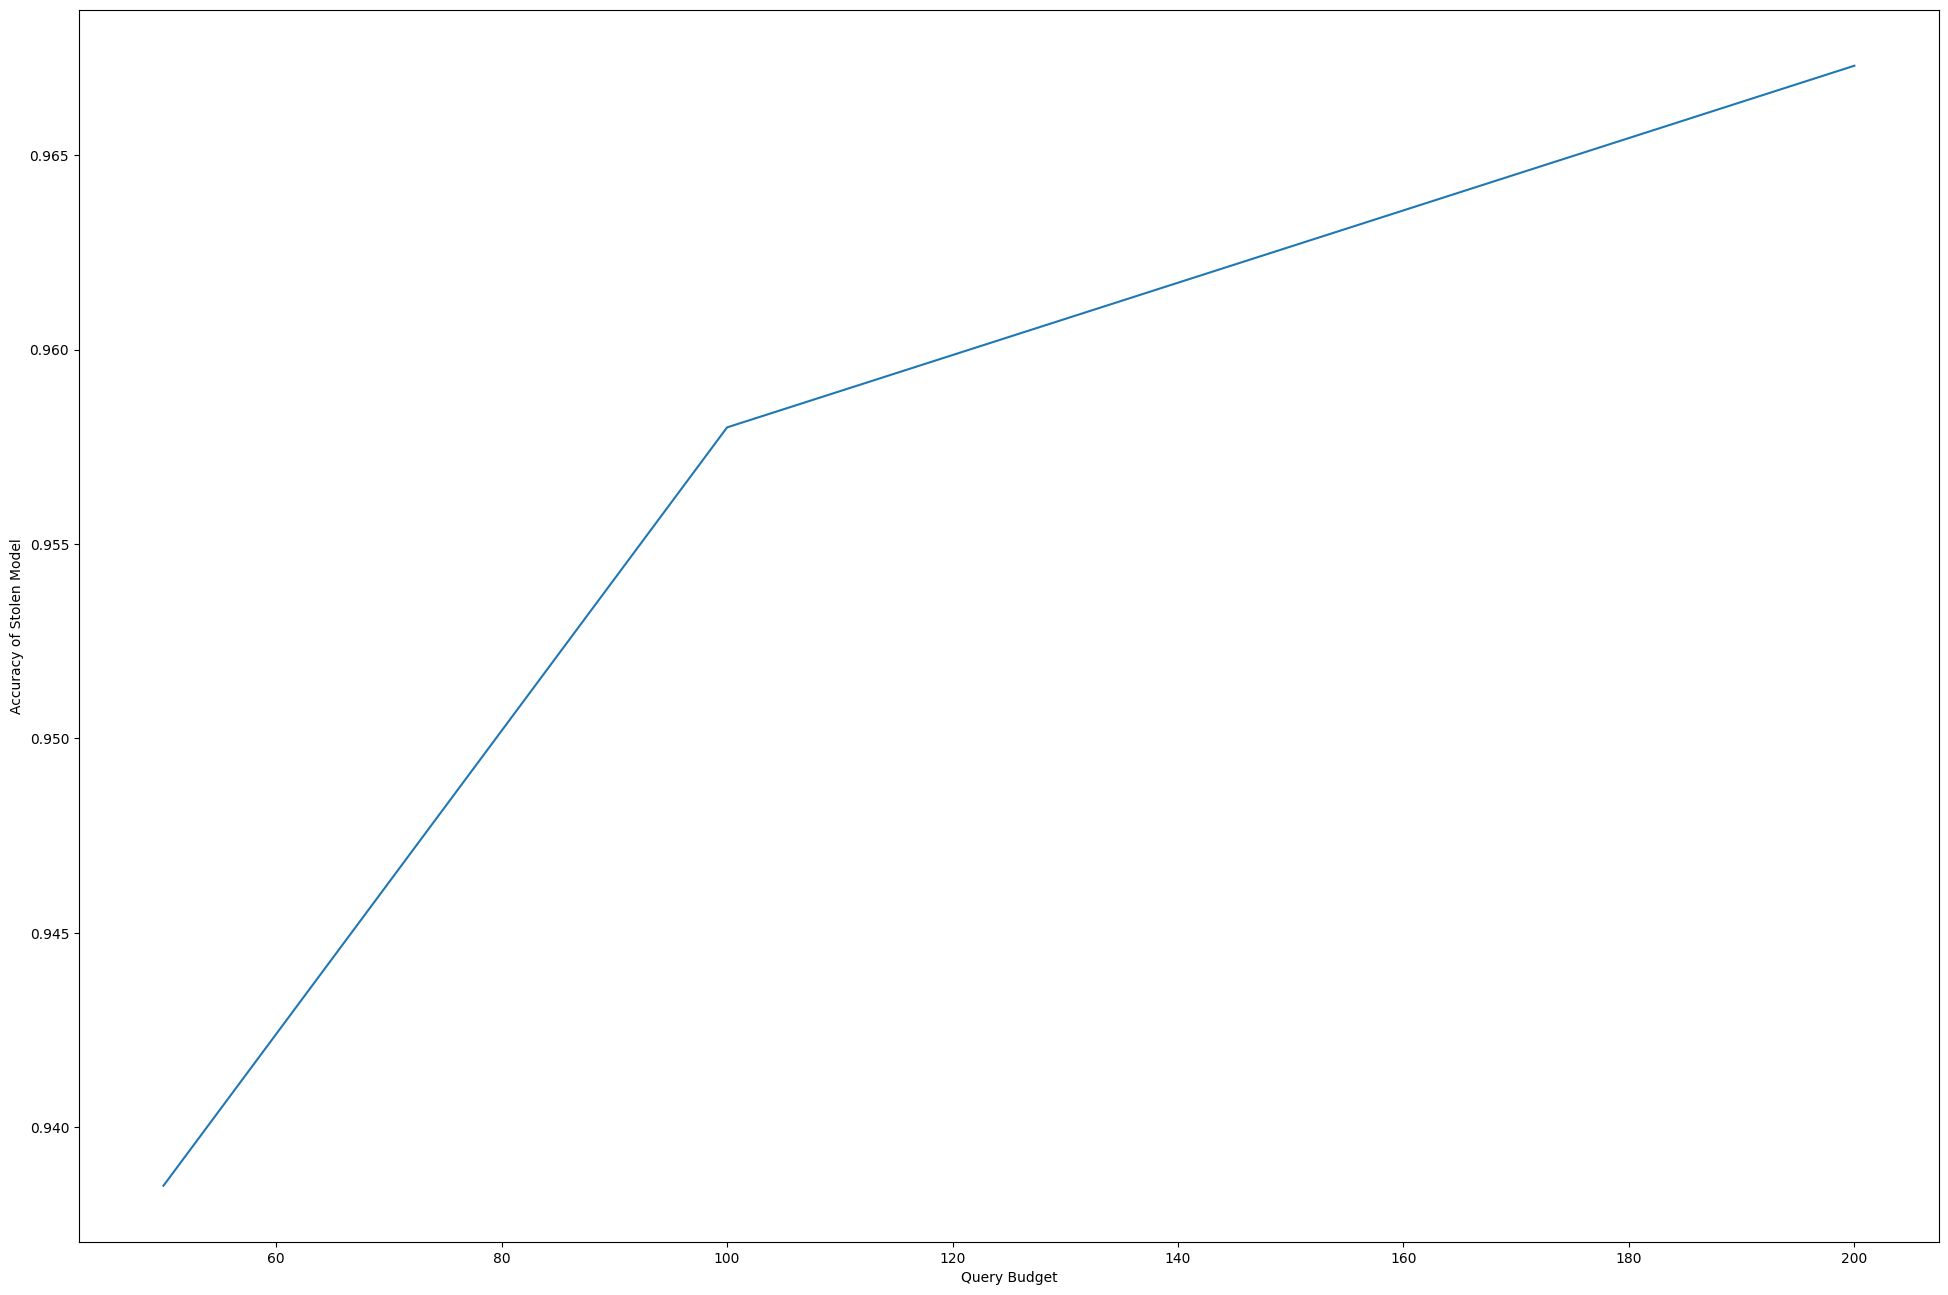

##### Experiment on query_budget=200, training_epoch=100 #####
Test Accuracy =  0.9515
Test Accuracy =  0.9619
Test Accuracy =  0.9639
Test Accuracy =  0.9655
Test Accuracy =  0.9666
Test Accuracy =  0.9672
Test Accuracy =  0.9675
Test Accuracy =  0.968
Test Accuracy =  0.968
Test Accuracy =  0.9678
##### Experiment on query_budget=100, training_epoch=100 #####
Test Accuracy =  0.9093
Test Accuracy =  0.9392
Test Accuracy =  0.9465
Test Accuracy =  0.9518
Test Accuracy =  0.9555
Test Accuracy =  0.9575
Test Accuracy =  0.9582
Test Accuracy =  0.9586
Test Accuracy =  0.9588
Test Accuracy =  0.9594
##### Experiment on query_budget=50, training_epoch=100 #####
Test Accuracy =  0.8196
Test Accuracy =  0.9057
Test Accuracy =  0.9177
Test Accuracy =  0.9248
Test Accuracy =  0.9284
Test Accuracy =  0.931
Test Accuracy =  0.9351
Test Accuracy =  0.9379
Test Accuracy =  0.9401
Test Accuracy =  0.9413


<Figure size 640x480 with 0 Axes>

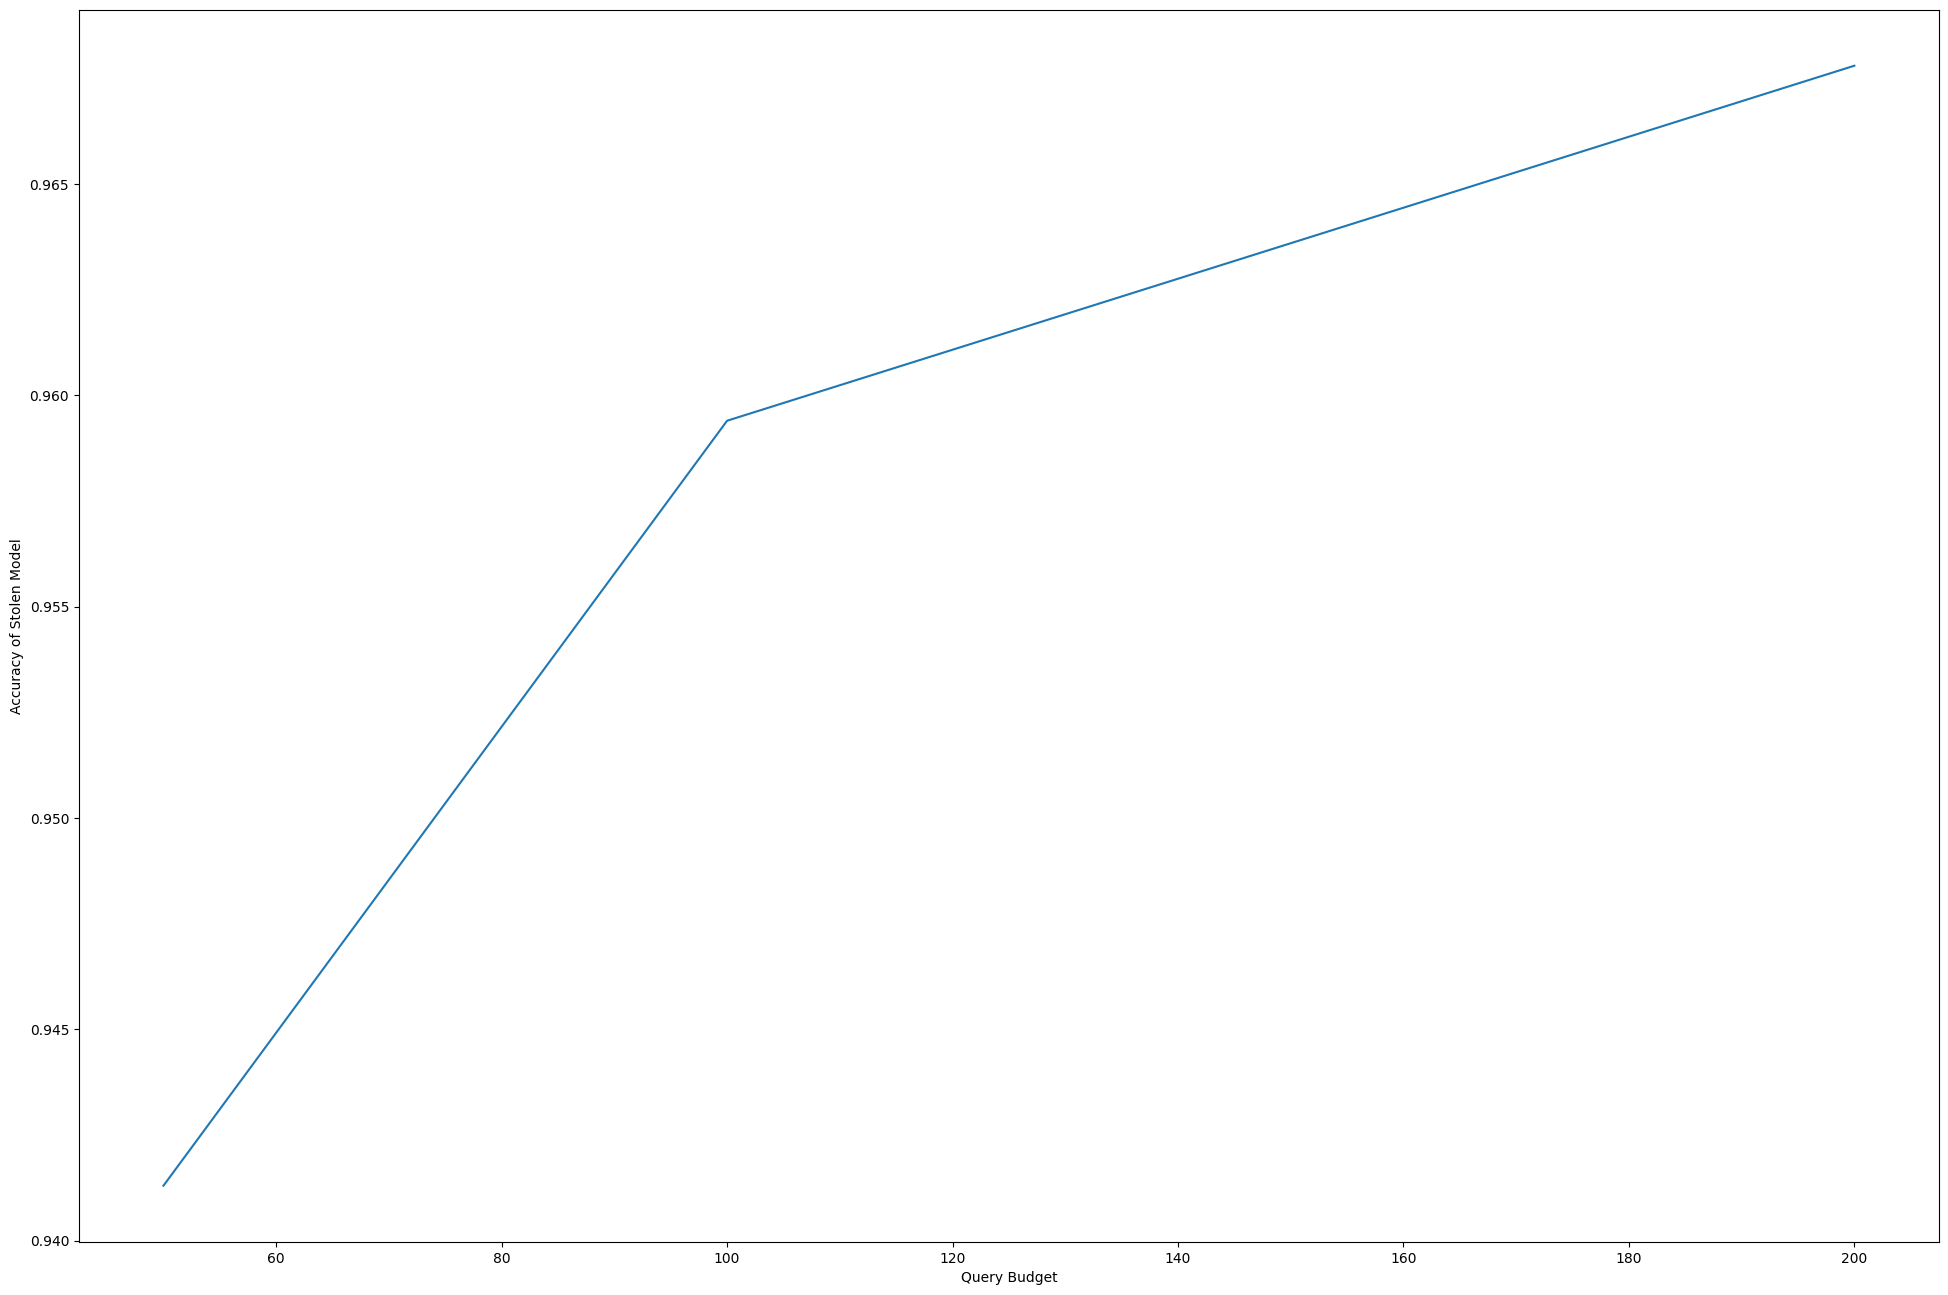

##### Experiment on query_budget=200, training_epoch=200 #####
Test Accuracy =  0.9519
Test Accuracy =  0.961
Test Accuracy =  0.9638
Test Accuracy =  0.9654
Test Accuracy =  0.9657
Test Accuracy =  0.9655
Test Accuracy =  0.9663
Test Accuracy =  0.9672
Test Accuracy =  0.9675
Test Accuracy =  0.9674
Test Accuracy =  0.9676
Test Accuracy =  0.9678
Test Accuracy =  0.9678
Test Accuracy =  0.9679
Test Accuracy =  0.968
Test Accuracy =  0.9683
Test Accuracy =  0.9686
Test Accuracy =  0.9686
Test Accuracy =  0.9692
Test Accuracy =  0.9689
##### Experiment on query_budget=100, training_epoch=200 #####
Test Accuracy =  0.9052
Test Accuracy =  0.9424
Test Accuracy =  0.9497
Test Accuracy =  0.9541
Test Accuracy =  0.9567
Test Accuracy =  0.9593
Test Accuracy =  0.9608
Test Accuracy =  0.9601
Test Accuracy =  0.961
Test Accuracy =  0.9621
Test Accuracy =  0.9627
Test Accuracy =  0.9624
Test Accuracy =  0.9631
Test Accuracy =  0.963
Test Accuracy =  0.9635
Test Accuracy =  0.9641
Test Accuracy 

<Figure size 640x480 with 0 Axes>

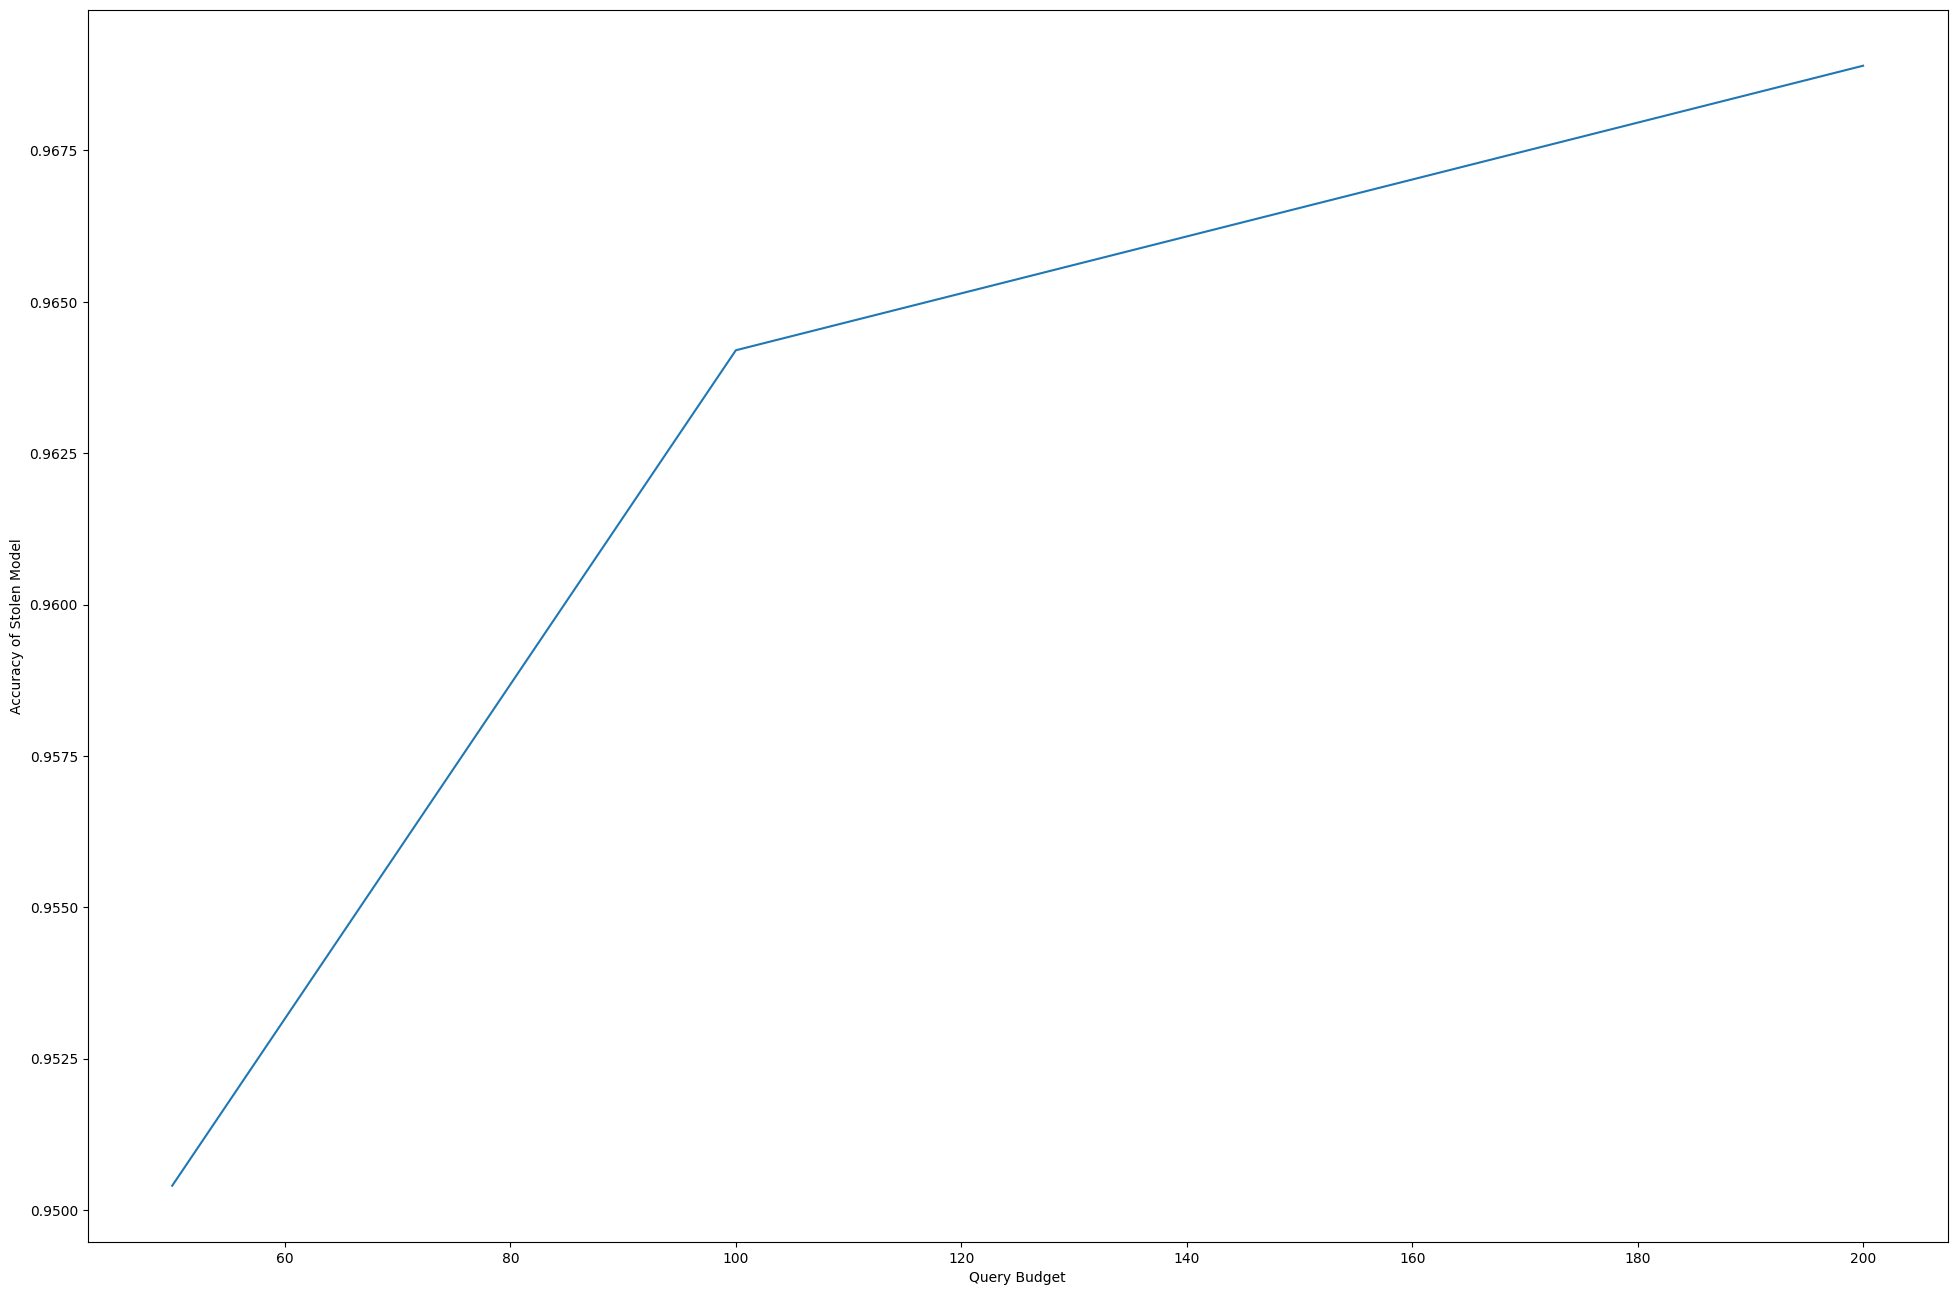

<Figure size 640x480 with 0 Axes>

In [87]:
# 攻击形式二
for epoches in epoches_list:
    acc_list = []
    
    for query_budget in query_budgets:
        print('##### Experiment on query_budget={}, training_epoch={} #####'.format(query_budget, epoches))
        # 初始化窃取模型
        query_set = np.load('Week13_MNIST_budget={}.npy'.format(query_budget), allow_pickle=True)       
        steal_model = LeNet5().to(device)
        optimizer = torch.optim.SGD(steal_model.parameters(), lr=learning_rate)
        x = torch.zeros(batch_size, 1, 28, 28, dtype=torch.float, device=device)
        y = torch.zeros(batch_size, 10, dtype=torch.float, device=device)
        
        for epoch in range(1, epoches + 1):
            for img, label in query_set:
                img = img.to(device)
                label = label.to(device)
                img = img.view(batch_size, 1, 28, 28)
                for batch in range(batch_size):
                    x[batch] = img[batch]
                    y[batch] = label[batch]
                # TODO：实现模型预测，loss计算和反传梯度的功能
                prediction = steal_model(x)
                pred_probs = torch.softmax(prediction, dim=1)
                target_probs = torch.softmax(y, dim=1)
                epsilon = 1e-10
                pred_probs = pred_probs + epsilon
                kl_div = torch.sum(target_probs * torch.log(target_probs / pred_probs), dim=1)
                loss = torch.mean(kl_div)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
            if epoch % 10 == 0:
                test_accuracy = test(steal_model, test_loader)
                print("Test Accuracy = ", test_accuracy)
        acc_list.append(test_accuracy)
        
    draw(query_budgets, acc_list, save_name='MNIST_KLSteal_Epoches={}.png'.format(epoches))
        